In [ ]:
#wget http://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_d.csv


In [1]:
import sys
sys.path.append('../')
sys.path.append('./')
import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.collections as collections
from talib.abstract import *
import copy

In [2]:
import talib as tb
def technical_indicators_df(daily_data):
        """
        Assemble a dataframe of technical indicator series for a single stock
        """
        o = daily_data['open'].values
        c = daily_data['close'].values
        h = daily_data['high'].values
        l = daily_data['low'].values
        v = daily_data['volume'].astype(float).values
        # define the technical analysis matrix

        # Most data series are normalized by their series' mean
        ta = pd.DataFrame()
        ta['MA5'] = tb.MA(c, timeperiod=5) 
        ta['MA10'] = tb.MA(c, timeperiod=10)
        ta['MA20'] = tb.MA(c, timeperiod=20) 
        ta['MA60'] = tb.MA(c, timeperiod=60) 
        ta['MA120'] = tb.MA(c, timeperiod=120) 
        ta['MA5'] = tb.MA(v, timeperiod=5) 
        ta['MA10'] = tb.MA(v, timeperiod=10)
        ta['MA20'] = tb.MA(v, timeperiod=20) 
        ta['ADX'] = tb.ADX(h, l, c, timeperiod=14) 
        ta['ADXR'] = tb.ADXR(h, l, c, timeperiod=14) 
        ta['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0] 
        ta['RSI'] = tb.RSI(c, timeperiod=14) 
        ta['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0] 
        ta['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] 
        ta['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2] 
        ta['AD'] = tb.AD(h, l, c, v) 
        ta['ATR'] = tb.ATR(h, l, c, timeperiod=14) 
        ta['HT_DC'] = tb.HT_DCPERIOD(c) 
        ta["High/Open"] = h / o
        ta["Low/Open"] = l / o
        ta["Close/Open"] = c / o
        ta.index=daily_data.index
        return ta

In [30]:
data = pd.read_csv('../data/webdata/Gemini_BTCUSD_d_20200306.csv',skiprows=1)

In [31]:
data['mid'] = 0.5 * (data['High'] + data['Low'])

In [32]:
windowsizes=[1,7,15,30,90]
for i in windowsizes:
    col_name = 'abs_rt_{}'.format(i)
    data[col_name] = data['mid'].shift(i)-data['mid'] 
    col_name = 'log_rt_{}'.format(i)
    data[col_name] = np.log(data['mid'].shift(i) / data['mid'])

In [33]:
data['Date']=data.apply(lambda row: datetime.strptime(row['Date'], '%Y-%m-%d'),axis=1)

data.set_index('Date', inplace=True)

data.sort_index(inplace=True)
data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume BTC': 'volume'}, inplace=True)

In [34]:

technical_index=technical_indicators_df(data)

technical_index.index=data.index


In [38]:
data.tail()

,Symbol,open,high,low,close,volume,Volume USD,mid,abs_rt_1,log_rt_1,abs_rt_7,log_rt_7,abs_rt_15,log_rt_15,abs_rt_30,log_rt_30,abs_rt_90,log_rt_90
Date,,,,,,,,,,,,,,,,,,
2020-03-02,BTCUSD,8528.40,8970.26,8488.18,8912.92,1244.69,10920151.93,8729.220,63.995,0.007304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,BTCUSD,8912.92,8921.42,8665.01,8751.88,910.91,7983225.26,8793.215,-32.980,-0.003758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,BTCUSD,8751.88,8850.47,8670.00,8757.05,1271.66,11148191.41,8760.235,201.695,0.022763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,BTCUSD,8757.05,9168.62,8755.24,9061.90,1794.76,16254601.18,8961.930,97.020,0.010768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,BTCUSD,9061.90,9061.90,9056.00,9056.00,0.00,0.00,9058.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#data=data.dropna()

In [ ]:
#is_na =  technical_index['MA120'].isna()


In [96]:
#technical_index[~is_na]
pred='log_rt_30'
filename=pred
#data[~data[pred].isna()]['log_rt_1']

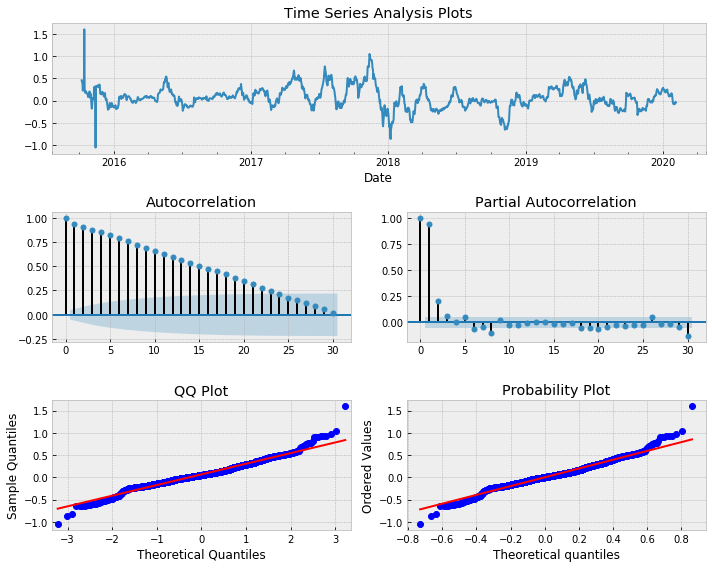

In [97]:
#import utils
fig=tsplot(data[pred].dropna(), lags=30)
fig.savefig('./test/'+filename+'.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


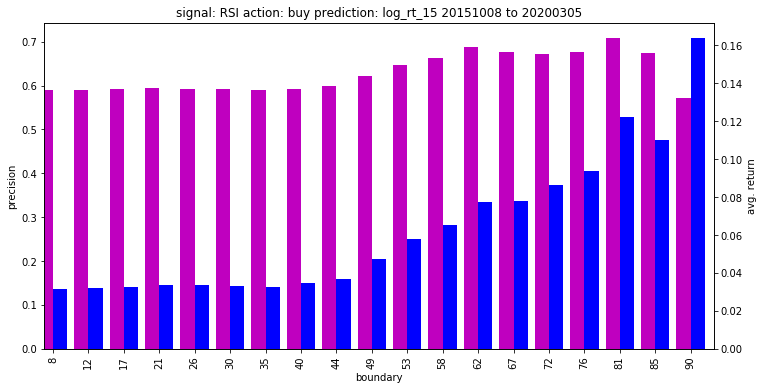

In [71]:
#import strategy_test
start=datetime(2015,10,8)
end=datetime(2020,3,5)
rules={'action':'buy','y':'log_rt_15','signal':'RSI'}
test=strategy_test(rules,technical_index,data)
test.signal_testing(start,end)

In [47]:
dates=[(datetime(2016,1,1),datetime(2016,12,31)),(datetime(2017,1,1),datetime(2017,12,31)),(datetime(2018,1,1),datetime(2018,12,31)),(datetime(2019,1,1),datetime(2019,12,31))]

In [ ]:
for start,end in dates:
    test.signal_testing(start,end)

In [63]:
class strategy_test(object):
    def __init__(self,rules,regressor,targets):
        """
        Set up a strategy env, feed in the data and initial status of the ledger

        :param env: market env collection
        :param initial: initial ledger status
        :param rules: controls over the strategy
        """
        self.regressor = regressor
        self.targets=targets
        self.rules = rules
    def stats_calc(self,tt,action=1):
        if action==-1:
            return OrderedDict([('sum', -1*tt.sum()), ('count',tt.count()), ('average', -1*tt.sum()/tt.count() if tt.count()>0 else 0)])    
        else:
            return OrderedDict([('sum', tt.sum()), ('count',tt.count()), ('average', tt.sum()/tt.count() if tt.count()>0 else 0)])
    
    def signal_stats(self,result,signal,pred,bd):
        stats=dict()
        if self.rules['action']=='buy':
            stats['FP']=self.stats_calc(result.loc[(result[signal]>bd) & (result[pred] <0)][pred])
            stats['TP']=self.stats_calc(result.loc[(result[signal]>bd) & (result[pred] >0)][pred])
        else:
            stats['FP']=self.stats_calc(result.loc[(result[signal]<bd) & (result[pred] >0)][pred])
            stats['TP']=self.stats_calc(result.loc[(result[signal]<bd) & (result[pred] <0)][pred])
        return stats

    def signal_testing(self, start, end):
        signal=self.rules['signal']
        pred=self.rules['y']
        result = pd.concat([self.regressor.loc[start:end,[signal]], self.targets.loc[start:end,[pred]]], axis=1, join='inner')
        result=result.dropna()
        l=int(result[signal].min())-1
        h=int(result[signal].max())+1
        hypers=[int(x) for x in np.linspace(l,h,20)]
        temp=[]
        for x in hypers:
            bd=x
            temp.append((int(x),self.signal_stats(result,signal,pred,bd)))
        summary= pd.DataFrame({"boundary":hypers, 
                       "avg_return":[(x[1]['FP']['sum']+x[1]['TP']['sum'])/(x[1]['FP']['count']+x[1]['TP']['count']) for x in temp],
                      "precision":[x[1]['TP']['count']/(x[1]['FP']['count']+x[1]['TP']['count']) for x in temp]})
        summary.set_index('boundary',inplace=True)
        summary.dropna(inplace=True)
        fig_width = 12
        fig_height = 6
        fig, ax = plt.subplots(figsize=(fig_width,fig_height))
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        width = 0.4

        summary['precision'].plot(kind='bar', color='m', ax=ax, width=width, position=1)
        summary['avg_return'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
        ax.set_title(' '.join(['signal:',signal,'action:',self.rules['action'],'prediction:',pred,start.strftime("%Y%m%d"),'to',end.strftime("%Y%m%d")]))
        ax.set_ylabel('precision')
        ax2.set_ylabel('avg. return')
        filename='_'.join([self.rules['action'],signal,pred,start.strftime("%Y%m%d"),end.strftime("%Y%m%d")])
        fig.savefig('./test/'+filename+'.png')

In [ ]:
''''low = min(y)
high = max(y)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

In [ ]:
class IndexedData(object):

    def __init__(self, source, request_dict, data):
        self.source = source
        #self.file_name = get_req_str(source, request_dict, False)
        self.index = request_dict
        self.data = data
        self.validate()